# Parametric EM (missing data)

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb


# the databases will be saved in "out/*.csv"
EMnomissing = "out/EM_nomissing.csv"
EMmissing = "out/EM_missing.csv"

## Generating data with missing values (at random)

In [2]:
src = gum.fastBN("A->B<-C->D->E<-B;D->F")
gum.generateSample(src, 5000, EMnomissing, random_order=False)
src

(pyagrum.BayesNet@0x55bbc5d01540) BN{nodes: 6, arcs: 6, domainSize: 64, dim: 14, mem: 224o}

In [3]:
import pandas as pd
import numpy as np


def add_missing(src, dst, proba):
  df = pd.read_csv(src)
  mask = np.random.choice([True, False], size=df.shape, p=[proba, 1 - proba])
  df.mask(mask).to_csv(dst, na_rep="?", index=False, float_format="%.0f")


gum.generateSample(src, 5000, EMnomissing, random_order=False)
add_missing(EMnomissing, EMmissing, proba=0.1)

In [4]:
print("No missing")
with open(EMnomissing, "r") as srcfile:
  for _ in range(10):
    print(srcfile.readline(), end="")
print("Missing")
with open(EMmissing, "r") as srcfile:
  for _ in range(10):
    print(srcfile.readline(), end="")

No missing
A,B,C,D,E,F
1,1,0,1,0,0
1,1,1,1,0,0
0,0,0,0,1,0
1,1,0,0,0,1
0,1,1,0,0,0
1,1,1,1,1,1
1,1,1,1,0,0
1,0,0,1,1,1
1,1,0,0,0,0
Missing
A,B,C,D,E,F
1,1,0,1,0,0
1,1,1,1,0,0
0,0,0,?,1,0
1,1,0,?,0,1
0,1,1,0,0,0
?,1,1,1,1,1
1,1,1,?,0,0
1,0,0,1,1,1
1,1,0,0,0,0


## Basic learning with missing data

Now we create the BNLearner, specifying:

1. the filename of the database
1. a Bayes net (src) that enables to easily specify the random variables of interest in this database as well as their features (domain, name, type, etc.)
1. a list of the strings encoding the missing data in the database

In [5]:
learner = gum.BNLearner(EMmissing, src, ["?"])
print(f"Missing values in {EMmissing} : {learner.hasMissingValues()}")

Missing values in out/EM_missing.csv : True


Learning the parameters of a Bayes net makes sense only for a given network structure since
they are the parameters of the conditional probability tables of the nodes (random variables)
given their parents in the graph. So, below, we pass in argument to Method `learnParameter()`
the graphical structure of Bayes net src. This is the most basic way of learning Bayes net
parameters with a BNLearner.

Note that, by default, the BNLearner is not capable of estimating parameters from a database
that contains missing values. Indeed, this requires a way to impute these missing values in order to
avoid introducing biases and we do not want to enforce a specific way to do so (for instance to
enforce using EM while the missing data are not missing completely at random).

In [6]:
try:
  learner.learnParameters(src.dag())
except gum.MissingValueInDatabase:
  print("Learning is not possible without EM if there are some missing values.")

Learning is not possible without EM if there are some missing values.


In this tutorial, the data are missing completely at random (MCAR), so we can safely
indicate to the BNLearner that we wish to use EM to impute missing values using the
Expectation/Maximization (EM) algorithm.

EM iterates expectation/maximizations steps, so we need some criteria to determine when it
is appropriate to stop these iterations. Method `useEM()` both lets the BNLearner know
that it must use EM and sets the primary stopping criterion of the algorithm to be the 
min log-likelihood evolution rate, i.e., at each iteration, EM computes the log-likelihood
of the data (after imputation). Let $LLc$ and $LLp$ be the log-likelihoods at the current
and the previous iterations respectively. Then, `useEM(1e-4)` specifies that EM should stop when 
$(LLc - LLp) / LLc < 10^{-4}$.

The "primary" stopping criterion refers to the fact that we can specify several criteria, including
a maximal number of iterations (MaxIter), a timeout (MaxTime). In the case where several criteria 
are specified, then EM stops when at least one criterion is not met. Printing the BNLearner, as 
shown below, shows you which stopping criteria EM uses.

In [7]:
learner.useEM(1e-4)

# at each iteration, EM estimates the parameters using a learning score and a prior.
# you can specify which ones you wish to use
learner.useSmoothingPrior()
print(learner)

# to be user-frendly, these methods can be chained:
learner.useEM(1e-3).useSmoothingPrior().useScoreAIC()

# perform the parameter learning using EM
bn = learner.learnParameters(src.dag())
gnb.flow.row(
  gnb.getInference(src),
  gnb.getInference(bn),
  captions=["Source", f"EM Estimation after {learner.EMnbrIterations()} iteration(s)"],
)

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : Smoothing
Prior weight         : 1.000000
use EM               : True
EM stopping criteria : [MinRate: 0.0001, MaxIter: 10000]



It may be interesting to know for which reason EM stopped its iterations. Method `EMStateMessage()` allows
you to know it. Notably, it is well-known that, using EM, the log-likelihood always
increases and will therefore converge. But, actually, this common knowledge is not
entirely accurate and it may happen, although this is very very unlikely, that the
log-likelihood decreases and diverges. See Table 5 on p28 of
__[EM_collins97.pdf](https://faculty.washington.edu/fxia/courses/LING572/EM_collins97.pdf)__.
In such a case, the BNLearner's EM algorithm returns the Bayes net with the highest
log-likelihood parameters and issues a warning. Method `EMStateMessage()` will then report
that EM has been stopped to avoid a log-likelihood divergence.

In [8]:
print("EM 1", learner.EMStateMessage())

# here, in addition to the log-likelihood min rate, we limit the number of iterations
learner.EMsetMaxIter(2)
bn = learner.learnParameters(src.dag())
print("EM 2", learner.EMStateMessage())

EM 1 stopped with rate=0.001
EM 2 stopped with max iteration=2


Sometimes, it is more convenient to get the state as an integer so that a program can handle it.
In this case, prefer using Method `EMStateApproximationScheme()`. The documentation of this method explains
the meanings of the returned numbers.

In [9]:
print("state =", learner.EMStateApproximationScheme())

help(gum.BNLearner.EMStateApproximationScheme)

state = 4
Help on function EMStateApproximationScheme in module pyagrum.pyagrum:

EMStateApproximationScheme(self) -> object
    Returns an int representing the state of the EM algorithm.

    The possible states are:
      0. Undefined
      1. Continue: EM has not been stopped yet
      2. Epsilon: EM has been stopped due to the min log-likelihood difference stopping criterion
      3. Rate: EM has been stopped due to the min log-likelihood evolution rate stopping criterion
      4. Limit: EM has been stopped due to a limit on the number of iterations
      5. TimeLimit: EM has been stopped due to a timeout
      6. Stopped: EM has been stopped because there was a divergence on the log-likelihood



If the data are not missing at random, we should not use EM. We can forbid it
specifying a rate of 0.0 in method `useEM()` or, preferably, using Method `forbidEM()`.

In [10]:
learner.forbidEM()

try:
  bn = learner.learnParameters(src.dag())
except gum.MissingValueInDatabase:
  print("Learning is not possible without EM if there are some missing values.")

Learning is not possible without EM if there are some missing values.


## Learning with smaller error (and no smoothing)

In [11]:
learner = gum.BNLearner(EMmissing, src, ["?"])

# here, we use EM in verbose mode in order to keep track of the log-likelihoods
# computed. This will allow us to plot them in the next notebook cell.
learner.useEM(1e-8).EMsetVerbosity(True)

bn2 = learner.learnParameters(src.dag())
gnb.flow.row(
  gnb.getInference(src),
  gnb.getInference(bn2),
  captions=["Source", f"EM Estimation after {learner.EMnbrIterations()} iteration(s)"],
)

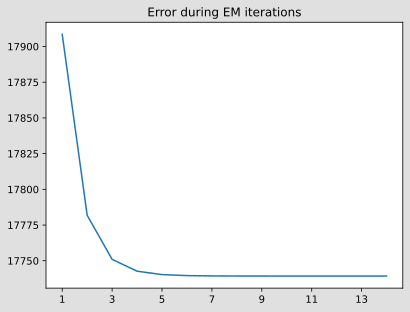

In [12]:
import matplotlib.pyplot as plt

# display -log-likelihood
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations");

## Setting EM's stopping criteria

There are 3 methods to enable EM:

<ol>
    <li><code>useEM()</code> that, implicitly, sets the log-likelihood evolution
        rate as the primary stopping criterion</li>
    <li><code>useEMWithRateCriterion()</code>, which is an alias for useEM()</li>
    <li><code>useEMWithDiffCriterion()</code>, which sets the difference between two consecutive
        log-likelihoods as the primary stopping criterion</li>
</ol>

learning with the min log-likelihood evolution rate criterion
stopped with rate=0.001


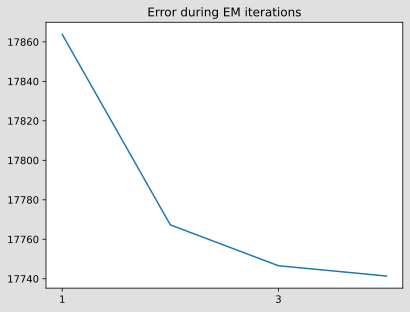

learning with the min log-likelihood difference criterion
stopped with epsilon=0.5


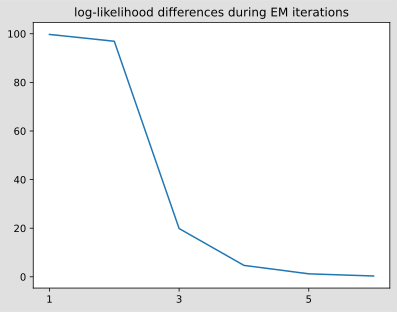

In [13]:
# here, we enable EM and enforce that it will stop when the log-likelihood
# evolution rate drops below 1e-3
print("learning with the min log-likelihood evolution rate criterion")
learner.useEMWithRateCriterion(1e-3)
learner.learnParameters(src.dag())
print(learner.EMStateMessage())

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations")
plt.show()

# setting EM to stop when the difference between two consecutive log-likelihood
# drops below 0.5
print("learning with the min log-likelihood difference criterion")
learner.useEMWithDiffCriterion(0.5)
learner.learnParameters(src.dag())
print(learner.EMStateMessage())

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("log-likelihood differences during EM iterations")
plt.show()

It is possible to specify several stopping criteria. In this case, EM stops
when at least one of the criteria is not met.<br/>
Note that Min log-likelihood difference and Min-log-likelihood evolution rate
are mutually exclusive.

In [14]:
# the following learner will stop whenever the difference between two consecutive
# log-likelihoods drops below 0.5 OR whenever it has performed 4 iterations OR
# whenever it has already been executed for 200 milliseconds.
learner.useEMWithDiffCriterion(0.5).EMsetMaxIter(4).EMsetMaxTime(200)

print(learner)

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : -
use EM               : True
EM stopping criteria : [MinDiff: 0.5, MaxIter: 4, MaxTime: 200]



In [15]:
# Of course, it is always possible to disable previously selected criteria
print(learner)

# remove the max iter criterion and the min diff criterion
learner.EMdisableMaxIter().EMdisableEpsilon()

print("================================")
print(learner)

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : -
use EM               : True
EM stopping criteria : [MinDiff: 0.5, MaxIter: 4, MaxTime: 200]

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : -
use EM               : True
EM stopping criteria : [MaxTime: 200]



## Initializing the EM algorithm

The EM's philosophy consists of imputing missing values using the Bayes net
learnt at the previous iteration. This means that it requires an initial
model. When using Method learnParameter(dag), this initial model has the graphical
structure corresponding to dag, and its parameters are learnt using an
estimator that does not take into account the missing values.

The conditional probability tables (CPT) of the initial Bayes net are then
perturbed, so that we can execute EM with multi-starts. More precisely,
the CPTs are perturbed using the following formula:
$$new\_CPT = (1-noise) \times CPT + noise \times random\_CPT,$$
where $noise$ is a real number belonging to interval $[0,1]$.

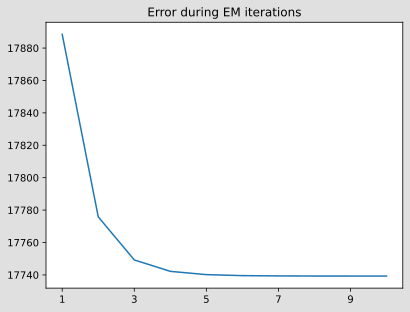

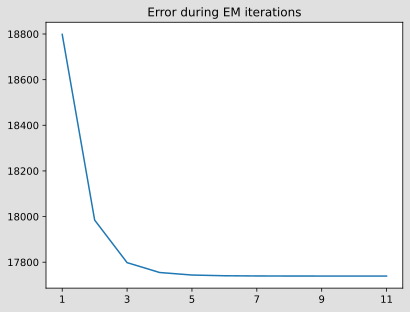

In [16]:
learner = gum.BNLearner(EMmissing, src, ["?"])

# by default, useEM specifies a default noise equal to 0.1
learner.useEM(1e-6).EMsetVerbosity(True)

# use the pyagrum estimator to initialize EM's CPTs and perturb them
# with the default 0.1 noise
learner.learnParameters(src.dag())

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations")
# define another noise
learner.useEM(1e-6, 0.9)  # noise = 0.9
learner.learnParameters(src.dag())

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations");

In the above cell, before perturbing the CPTs of the EM's initial model,
those were estimated from the dataset. This prevents exploiting user knowledge.
To fix this issue, instead of passing a DAG as a parameter to Method
`learnParameters()`, it is possible to pass a Bayes net. In this
case, for the CPTs of this Bayes net that are fully filled with zeroes, EM's
initial CPTs are estimated as described above, but the other CPTs are considered 
as the initial values to be taken into account before the noise perturbations.

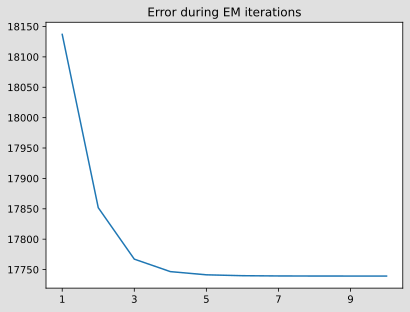

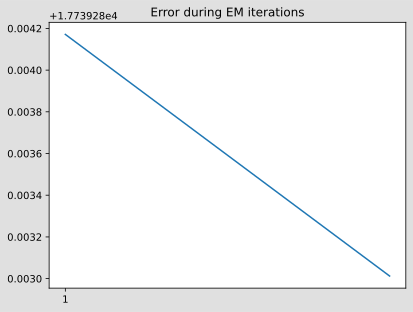

In [17]:
# first learning with EM
learner.useEM(1e-6, 0.9)
bn = learner.learnParameters(src.dag())

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations")
# relaunch EM but initializing the CPTs with those of bn
learner.useEM(1e-6, 0.0)  # no noise
learner.learnParameters(bn)

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations");

In [18]:
# of course, not all the CPTs need be initialized by the user
bn.cpt("A").fillWith([0.0] * 2)
bn.cpt("B").fillWith([0.0] * 8)
bn.cpt("D").fillWith([0.0] * 4)
bn.cpt("F").fillWith([0.0] * 4)

gnb.sideBySide(
  bn.cpt("A"),
  bn.cpt("B"),
  bn.cpt("C"),
)

gnb.sideBySide(bn.cpt("D"), bn.cpt("E"), bn.cpt("F"))

The CPTs of $C$ and $E$ are initialized as shown in the preceding cell, the
other ones are estimated from the database. Then all the CPTs are
perturbed and EM starts its expectation/maximization iterations

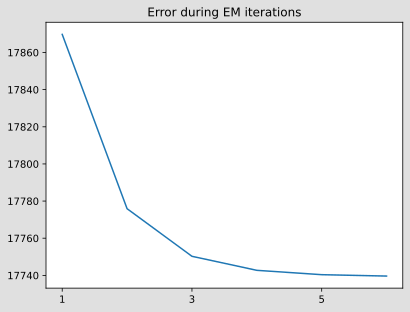

In [20]:
learner.useEM(1e-4)
learner.setVerbosity(True)
bn = learner.learnParameters(bn)

plt.figure()
plt.plot(np.arange(1, 1 + learner.EMnbrIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.EMnbrIterations(), step=2))
plt.title("Error during EM iterations");